In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# PIL
from PIL import Image
import tensorflow as tf
# build dataset with datagenerator
from keras.preprocessing.image import ImageDataGenerator

In [10]:
train_0_path = 'resize_data/train_img/0/'
train_1_path = 'resize_data/train_img/1/'
test_0_path = 'resize_data/test_img/0/'
test_1_path = 'resize_data/test_img/1/'

In [11]:
# save the image name in a list
train_0 = os.listdir(train_0_path)
train_1 = os.listdir(train_1_path)
test_0 = os.listdir(test_0_path)
test_1 = os.listdir(test_1_path)

# check the number of images
print('Number of train_0 images: ', len(train_0))
print('Number of train_1 images: ', len(train_1))
print('Number of test_0 images: ', len(test_0))
print('Number of test_1 images: ', len(test_1))

Number of train_0 images:  35552
Number of train_1 images:  34883
Number of test_0 images:  8889
Number of test_1 images:  8723


In [12]:
# create a data generator
datagen = ImageDataGenerator(rescale=1./255)

# prepare an iterators for each dataset
train_it = datagen.flow_from_directory('resize_data/train_img/',
                                        class_mode='binary',
                                        batch_size=64,
                                        target_size=(224, 224))
test_it = datagen.flow_from_directory('resize_data/test_img/',  
                                        class_mode='binary',
                                        batch_size=64,
                                        target_size=(224, 224))


Found 70435 images belonging to 2 classes.
Found 17612 images belonging to 2 classes.


In [13]:
# use resnet50 as the base model and fine-tune the model
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [14]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- we have 2 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [15]:
# check the number of gpu available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7265071826491209115
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10158781248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9096003839944336263
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


2023-03-04 23:19:23.784550: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-04 23:19:23.784754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 23:19:23.784952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2023-03-04 23:19:23.784987: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-04 23:19:23.785009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-04 23:19:23.785022: I tensorflow/stream_executor/plat

In [16]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
# train the model and show the f1 score
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score

# define the checkpoint
checkpoint = ModelCheckpoint('resnet50.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# define the early stopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='max')

# fit the model
history = model.fit(train_it,
                    steps_per_epoch=len(train_it),
                    validation_data=test_it,
                    validation_steps=len(test_it),
                    epochs=100,
                    callbacks=[checkpoint, early])


2023-03-04 23:19:24.598914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-04 23:19:24.599393: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3399905000 Hz


Epoch 1/100


2023-03-04 23:19:26.815519: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-04 23:19:26.966697: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1101/1101 [==============================] - 177s 157ms/step - loss: 0.7825 - accuracy: 0.5453 - val_loss: 0.6064 - val_accuracy: 0.6941

Epoch 00001: val_accuracy improved from -inf to 0.69407, saving model to resnet50.h5
Epoch 2/100
1101/1101 [==============================] - 173s 157ms/step - loss: 0.6232 - accuracy: 0.6482 - val_loss: 0.5772 - val_accuracy: 0.7049

Epoch 00002: val_accuracy improved from 0.69407 to 0.70486, saving model to resnet50.h5
Epoch 3/100
1101/1101 [==============================] - 173s 158ms/step - loss: 0.6057 - accuracy: 0.6665 - val_loss: 0.6607 - val_accuracy: 0.6107

Epoch 00003: val_accuracy did not improve from 0.70486
Epoch 4/100
1101/1101 [==============================] - 173s 157ms/step - loss: 0.5905 - accuracy: 0.6798 - val_loss: 0.5712 - val_accuracy: 0.7009

Epoch 00004: val_accuracy did not improve from 0.70486
Epoch 5/100
1101/1101 [==============================] - 173s 157ms/step - loss: 0.5832 - accuracy: 0.6886 - val_loss: 0.5649 - v

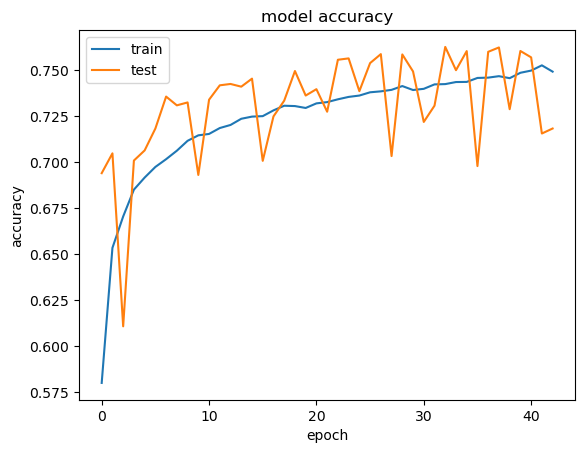

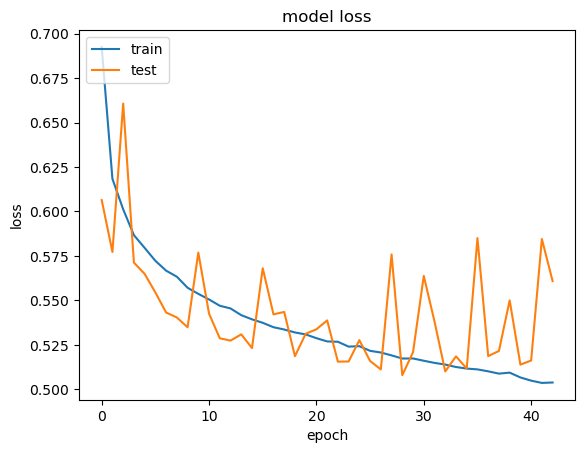

In [18]:
# plot the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
# evaluate the model with all the test data
test_loss, test_acc = model.evaluate(test_it, verbose=2)
print('Test accuracy:', test_acc)
# f1 score
y_pred = model.predict(test_it)
y_pred = np.round(y_pred)
y_true = test_it.classes
f1 = f1_score(y_true, y_pred)
print('F1 score: ', f1)

276/276 - 35s - loss: 0.5609 - accuracy: 0.7184
Test accuracy: 0.7183738350868225
F1 score:  0.405089127772486
